<a href="https://www.kaggle.com/code/irasim/hotels-score-pred-model?scriptVersionId=91632148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

import pandas as pd
import category_encoders as ce
from sklearn import preprocessing
 
from sklearn.model_selection import train_test_split  

# for url requests
import requests
from bs4 import BeautifulSoup as bs
# for cooordinates of main attractions and distance
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Automated assessment of the reviews: Sentiment analysis 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# For training and model evaluation
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [31]:
input_dir = '../input/sf-booking/'
train = pd.read_csv(input_dir + 'hotels_train.csv')
print(train.shape)

(386803, 17)


In [32]:
print(train.columns)

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')


In [33]:
# Info about the country a reviewer is from

url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)
soup = bs(page.content, 'html.parser')
tbl = soup.find("table")
country_stats= pd.read_html(str(tbl))[0]

country_stats['Country'] = country_stats['Country'].str.strip()

In [34]:
# Reviews analysis
# sent_analyzer = SentimentIntensityAnalyzer()
# train['rw_neg'] = train['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# train['rw_pos'] = train['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# train.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(train['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
# train.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(train['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

# train.head(2)

In [35]:
#train.tags = train.tags.apply(lambda x: x[3:-3].split(" ', ' "))
# Top tags
#top_tags = list(train.tags.explode().value_counts().index)[:15]
#top_tags


In [36]:
# train['no_neg'] = 0
# train['no_pos'] = 0

# no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil',
#                'nothing at all', 'na', 'nothing to dislike', 'liked everything', 'can t think of anything', 
#                'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 
#                'nothing to complain about', 'non', 'having to leave', 'nothing not to like', 'leaving',
#                'nothing not to like', 'everything was good', 'all was good', 'not applicable', 'i liked everything', 'all was good ', 'no thing', 'nothing all good']

# train.loc[train['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
# train.loc[train['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
# train.loc[train['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

# train['negative_review'].value_counts()[:10]

# no_pos_list = ['no positive', 'nothing']

# train.loc[train['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
# train.loc[train['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1
# train.loc[train['positive_review'].str.lower().str.strip().isin(no_pos_list), 'positive_review'] = ''

# train['positive_review'].value_counts()[:50]'

In [37]:
# Outliers method Tukay
def outliers_iqr_mod(data, feature, left = 1.5, right = 1.5):
        x = data[feature]
        quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * left)
        upper_bound = quartile_3 + (iqr * right)
        outliers = data[(x<lower_bound) | (x > upper_bound)]
        cleaned = data[(x>lower_bound) & (x < upper_bound)]
        return outliers, cleaned

In [38]:
def data_transform(df): 
    hotels = df
    hotels['review_date'] = pd.to_datetime(hotels['review_date'] ) # change to date format

    # Create variable: country
    hotels['country'] = hotels['hotel_address'].str.split(' ').str[-1] # Split the last word of the address
    hotels['country'] = hotels['country'].replace('Kingdom', 'UK')
    # Creating dummies for countries
    hotels['france'] = hotels['country'].apply(lambda x: 1 if x == 'France' else 0)
    hotels['italy'] = hotels['country'].apply(lambda x: 1 if x == 'Italy' else 0)
    hotels['uk'] = hotels['country'].apply(lambda x: 1 if x == 'UK' else 0)
    hotels['spain'] = hotels['country'].apply(lambda x: 1 if x == 'Spain' else 0)
    hotels['austria'] = hotels['country'].apply(lambda x: 1 if x == 'Austria' else 0)
    hotels['netherlands'] = hotels['country'].apply(lambda x: 1 if x == 'Netherlands' else 0)
   
    # Info from tags
    # Trip type
    hotels['Business trip'] =  hotels['tags'].str.contains('Business trip')
    hotels['Leisure trip'] =  hotels['tags'].str.contains('Leisure trip')

    # Suitable for
    hotels['Couple'] =  hotels['tags'].str.contains('Couple')
    hotels['Solo traveler'] =  hotels['tags'].str.contains('Solo traveler')
    hotels['Group'] =  hotels['tags'].str.contains('Group')
    hotels['With a pet'] =  hotels['tags'].str.contains('With a pet')
    hotels['Family with older children'] =  hotels['tags'].str.contains('Family with older children')
    hotels['Family with young children'] =  hotels['tags'].str.contains('Family with young children')
    hotels['Travelers with friends'] =  hotels['tags'].str.contains('Travelers with friends')

    # Nights stayed
    regex = 'Stayed +\d+' # Regex for numbers
    hotels['nights stayed'] = hotels['tags'].str.findall(regex).str.get(0)
    hotels['nights stayed'] = hotels['nights stayed'].str.split(' ', expand=True)[1]

    hotels['nights stayed'] = pd.to_numeric(hotels['nights stayed'] )

    hotels['1 night'] = hotels['nights stayed'].apply(lambda x: 1 if x == 1 else 0)
    hotels['2 night'] = hotels['nights stayed'].apply(lambda x: 1 if x == 2 else 0)
    hotels['3 night'] = hotels['nights stayed'].apply(lambda x: 1 if x == 3 else 0)
    hotels['4 night'] = hotels['nights stayed'].apply(lambda x: 1 if x == 4 else 0)
    hotels['5 night'] = hotels['nights stayed'].apply(lambda x: 1 if x == 5 else 0)
    hotels['between 6 and 14'] = hotels['nights stayed'].apply(lambda x: 1 if (x >5) & (x<15)  else 0)
    hotels['more than 15 days'] = hotels['nights stayed'].apply(lambda x: 1 if x>15 else 0)

    nights = ['1 night', '2 night', '3 night', '4 night', '5 night', 'between 6 and 14', 'more than 15 days']

    # Negative / positive reviews yes or no proxies
    hotels['No negative review'] = hotels['negative_review'].str.contains('No negative|Nothing|nothing', regex= True, case = False)
    hotels['No positive review'] = hotels['positive_review'].str.contains('No positive|nothing', regex = True, case = False)
    reviews =  ['No negative review', 'No positive review']
    
    # alternative no negative reviews 
    hotels['no_neg'] = 0
    hotels['no_pos'] = 0
    
    no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil',
                   'nothing at all', 'na', 'nothing to dislike', 'liked everything', 'can t think of anything', 
                   'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 
                   'nothing to complain about', 'non', 'having to leave', 'nothing not to like', 'leaving',
                   'nothing not to like', 'everything was good', 'all was good', 'not applicable', 'i liked everything', 
                   'all was good ', 'no thing', 'nothing all good']
    hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
    hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
    
    no_pos_list = ['no positive', 'nothing']
    hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
    #train.loc[train['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1
    
    hotels.loc[hotels['no_neg'] == 1, 'review_total_negative_word_counts'] = 0
    
    hotels['perc_pos_word_count'] = hotels['review_total_positive_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts']+1)
    hotels['perc_neg_word_count'] = hotels['review_total_negative_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts']+1)
    
    # Year, month of the review
    hotels['year'] = pd.DatetimeIndex(hotels['review_date']).year
    hotels['month'] = pd.DatetimeIndex(hotels['review_date']).month
    hotels['dayofweek'] = pd.DatetimeIndex(hotels['review_date']).weekday
    hotels['weekend'] = hotels['dayofweek'].apply(lambda x: 1 if (x == 5 or x == 6) else 0)
    
    hotels['days_since_review'] = (( hotels['review_date'].max() -  hotels['review_date'])/np.timedelta64(1,'D')).astype(int)

    # One hot encoding year
    encoder = ce.OneHotEncoder(cols = ['year'])
    bin = encoder.fit_transform(hotels['year'])
    hotels = pd.concat([hotels, bin], axis=1)

    # One hot encoding month
    encoder = ce.OneHotEncoder(cols = ['month'])
    bin = encoder.fit_transform(hotels['month'])
    hotels = pd.concat([hotels, bin], axis=1)
    
    hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip() # drop the spaces in the beg and end
    hotels = hotels.merge(country_stats, how = 'left', left_on= 'reviewer_nationality', right_on= 'Country'  )
    
    # Filling in missing values
    values = {

        'lat': hotels['lat'].mode()[0],
        'lng': hotels['lng'].mode()[0],
        'Gini % - World Bank': hotels['Gini % - World Bank'].mean(), 
        '2022 Population': hotels['2022 Population'].mean()
    }
    hotels = hotels.fillna(values)
    
    
    # creating tuple with coordinates of main attractions 
    geolocator = Nominatim(user_agent="Your_Name")

    address='Louvre Museum'
    paris = geolocator.geocode(address)
    address='Duomo di Milano'
    milano = geolocator.geocode(address)
    address='Buckingham Palace'
    london = geolocator.geocode(address)
    address='Hofburg'
    vienna = geolocator.geocode(address)
    address='Rijksmuseum'
    amsterdam = geolocator.geocode(address)
    address='Sagrada Família'
    barcelona = geolocator.geocode(address)

    paris_coor = (paris.latitude, paris.longitude)
    milano_coor = (milano.latitude, milano.longitude)
    london_coor = (london.latitude, london.longitude)
    vienna_coor = (vienna.latitude, vienna.longitude)
    amsterdam_coor = (amsterdam.latitude, amsterdam.longitude)
    barcelona_coor = (barcelona.latitude, barcelona.longitude)

    # making tuple of coordinates
    hotels['coordinates'] = hotels[['lat', 'lng']].apply(tuple, axis = 1)
    # matching the main attraction and the city
    hotels['main_attraction'] = hotels['country'].apply(lambda x: london_coor if x == 'UK' 
                                                        else (milano_coor if x == 'Italy' 
                                                              else (barcelona_coor if x == 'Spain' 
                                                                    else (amsterdam_coor if x == 'Netherlands' 
                                                                          else(paris_coor if x == 'France' 
                                                                               else ( vienna_coor if x == 'Austria' else 0))))))
    # getting distance between the main attraction and the hotel
    hotels['distance'] = hotels.apply(lambda x: geodesic(x['coordinates'], x['main_attraction']).kilometers, axis = 1)
        
    # Review analysis
    sent_analyzer = SentimentIntensityAnalyzer()
    hotels['rw_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
    hotels['rw_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
    # Creating separate variables with the information about sentiment analysis
    hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)    
    return hotels
    


In [39]:
train = data_transform(train)
train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,rw_neg,rw_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,0,1994,Staff were amazing,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,1.000,0.0,0.0000,0.0,0.345,0.655,0.5859
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.756,0.244,0.0,-0.4767,0.0,1.000,0.000,0.0000


In [40]:
# Outliers method Tukey
outliers, train = outliers_iqr_mod(train,'distance' , 1, 7 )
#outliers, train = outliers_iqr_mod(train,'review_total_negative_word_counts' , 1, 15 )
#outliers, train = outliers_iqr_mod(train,'review_total_positive_word_counts' , 1, 15 )

In [41]:
countries = ['france', 'italy', 'uk', 'spain', 'austria', 'netherlands']
tags = ['Business trip', 'Leisure trip', 'Couple', 'Solo traveler', 'Group', 'With a pet', 
            'Family with older children', 'Family with young children', 'Travelers with friends']
nights = ['1 night', '2 night', '3 night', '4 night', '5 night', 'between 6 and 14', 'more than 15 days']
#reviews =  ['No negative review', 'No positive review']
reviews =  ['no_neg', 'no_pos']
review_timing = ['year', 'month', 'weekend']

cat_cols = countries + reviews + tags + nights + review_timing

nationality_stats = ['Gini % - World Bank', '2022 Population']

num_cols = ['average_score', 'perc_pos_word_count', 'perc_neg_word_count', 
            'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'distance', 'days_since_review', 
            'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound']


num_cols = num_cols + nationality_stats

variables_rf = num_cols + cat_cols

In [42]:
X = train[variables_rf]
y = train['reviewer_score'] 

<AxesSubplot:>

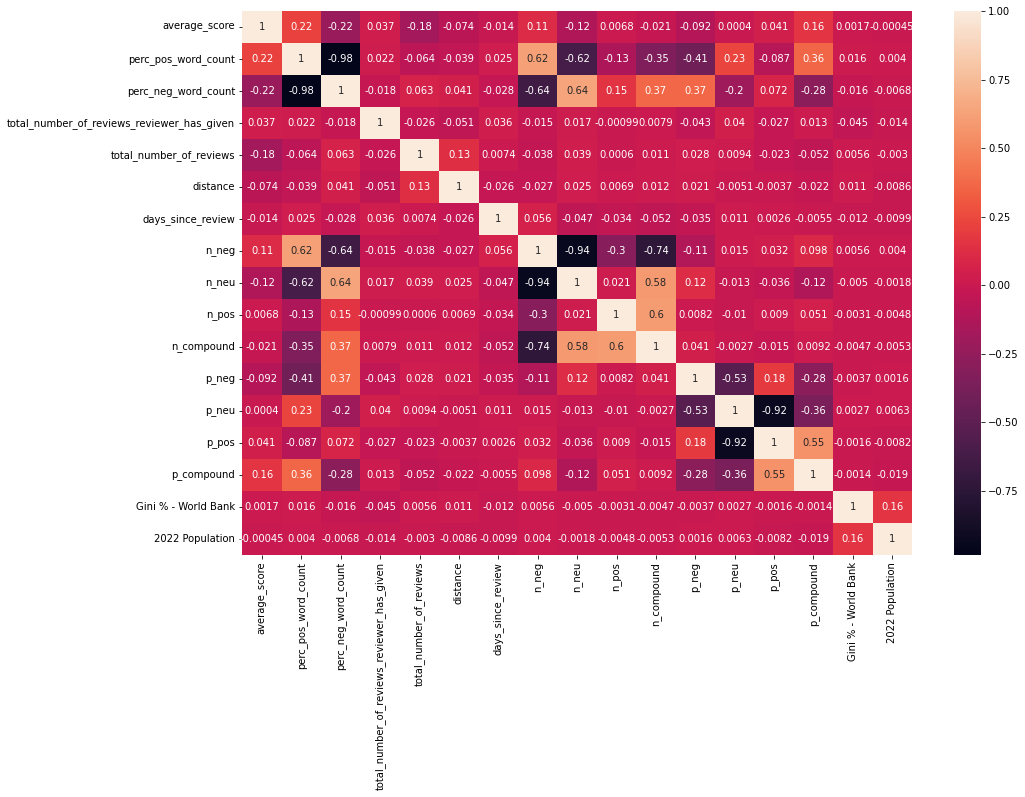

In [43]:
# Check for multicollinearity of continuous variables
fig= plt.figure(figsize=(15,10))
sns.heatmap(X[num_cols].corr(), annot=True) 

<AxesSubplot:>

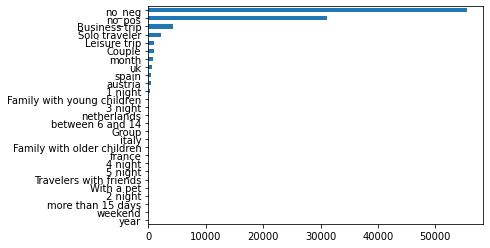

In [44]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # chi-squared

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

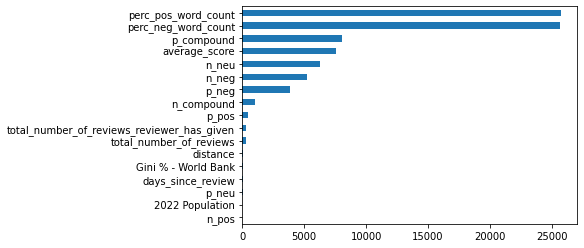

In [45]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [46]:
# Split data into training (train - 75%) and validation (test- 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

regr = RandomForestRegressor(n_estimators=100,  random_state = 42)  
#  Train the model
regr.fit(X_train, y_train)  
      
# Create predictions
y_pred = regr.predict(X_test)  
mape_modified = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14611872801872963


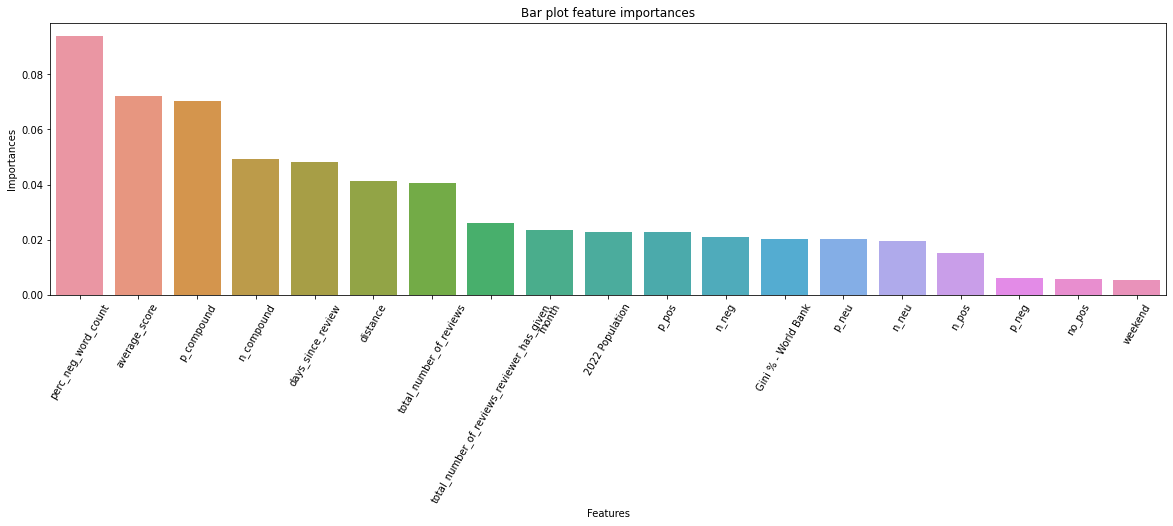

In [47]:
# Check feature importance
fig, ax = plt.subplots(figsize=(20, 5))
feature = X_train.columns
feature_importances = regr.feature_importances_
feature_importances = pd.Series(feature_importances)
feature_importances.index = feature
feature_importances = feature_importances.sort_values(ascending = False).rename('importance').reset_index()[1:20]
sns.barplot(data = feature_importances, x ='index',  y='importance', ax=ax);
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.xaxis.set_tick_params(rotation=60);

# Create predictions

In [48]:
input_dir = '../input/sf-booking/'
test = pd.read_csv(input_dir + 'hotels_test.csv')
print(test.shape)

(128935, 16)


In [49]:
submission = pd.read_csv('../input/sf-booking/submission.csv')
print(submission.shape)
submission.head(2)

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649


In [50]:
# Info about the country a reviewer is from

url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)
soup = bs(page.content, 'html.parser')
tbl = soup.find("table")
country_stats= pd.read_html(str(tbl))[0]

country_stats['Country'] = country_stats['Country'].str.strip()

In [51]:
test = data_transform(test)
test_data = test[variables_rf]
test_pred = regr.predict(test_data)
submission['reviewer_score'] = test_pred
submission.to_csv('my_submission_2.csv', index = False)